# Variational Autoencoders

- In Variational autoencoders the latent space is not made up of point vectors instead the inputs are mapped onto a normal distribution.
- latent space of a VAE is continuous, that enables us to sample from any part of it to generate new outputs (e.g. new images), making VAE a generative model.
- To achieve the desired regularity we add the Kulback-Leibler divergence (KL divergence).

## Step 1: Import libraries

In [1]:
# Tensorflow / Keras
# Importing necessary libraries from TensorFlow and Keras for building neural networks
from tensorflow import keras  # Importing TensorFlow's Keras API
from keras.models import Model  # For creating and assembling a neural network model
from keras import Input  # For instantiating a Keras tensor and specifying input dimensions
from keras.layers import Dense, Lambda  # For adding layers to the neural network model
from tensorflow.keras.utils import plot_model  # For plotting the model diagram
from keras import backend as K  # For accessing the Keras backend for reparameterization and creating custom loss functions

# Data manipulation
import numpy as np  # Importing NumPy for data manipulation
print('numpy: %s' % np.__version__)  # Print the version of NumPy library

# Visualization
import matplotlib  # Importing Matplotlib for plotting model loss
import matplotlib.pyplot as plt  # For plotting model loss
print('matplotlib: %s' % matplotlib.__version__)  # Print the version of Matplotlib library
import graphviz  # For showing the model diagram
print('graphviz: %s' % graphviz.__version__)  # Print the version of Graphviz library
import plotly  # Importing Plotly for data visualization
import plotly.express as px  # For data visualization
print('plotly: %s' % plotly.__version__)  # Print the version of Plotly library

# Other utilities
import sys  # For system-specific parameters and functions
import os  # For interacting with the operating system

# Assign main directory to a variable
main_dir = os.path.dirname(sys.path[0])  # Set the main directory to the parent directory of the current working directory

numpy: 1.25.2
matplotlib: 3.7.1
graphviz: 0.20.3
plotly: 5.15.0


## Step 2: Prepare the data

Shape of X_train:  (60000, 28, 28)
Shape of y_train:  (60000,)
Shape of X_test:  (10000, 28, 28)
Shape of y_test:  (10000,)


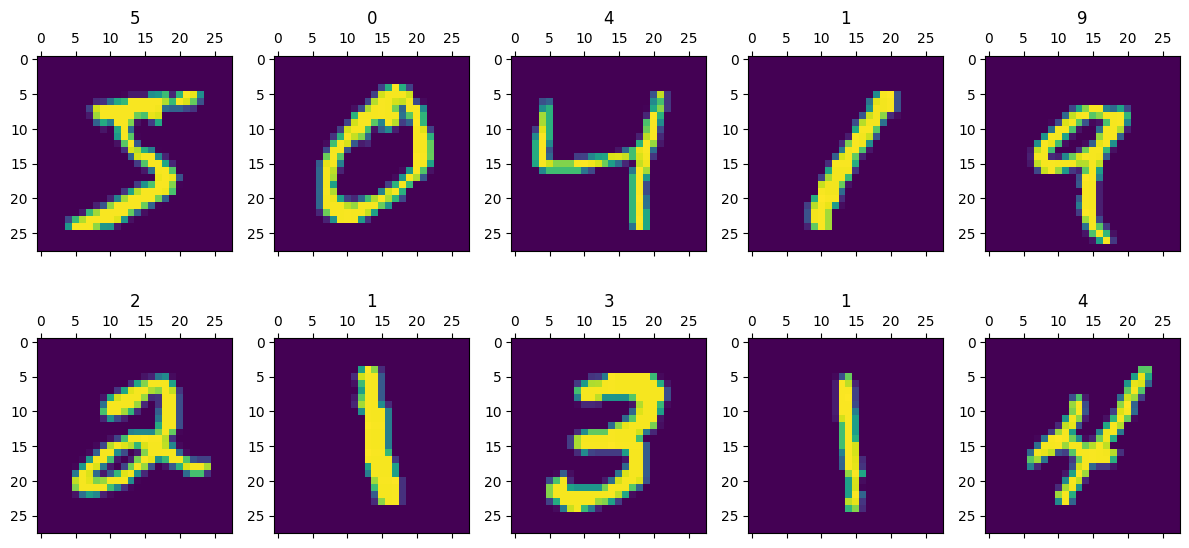

In [2]:
# Load digits data
# Load the MNIST dataset, which contains images of handwritten digits along with their labels.
# The dataset is divided into training and test sets.
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Print shapes
# Display the shapes of the loaded datasets.
print("Shape of X_train: ", X_train.shape)  # Print the shape of the training data
print("Shape of y_train: ", y_train.shape)  # Print the shape of the training labels
print("Shape of X_test: ", X_test.shape)    # Print the shape of the test data
print("Shape of y_test: ", y_test.shape)    # Print the shape of the test labels

# Normalize input data (divide by 255)
# Normalize the pixel values of the input images by dividing by 255.
# This step ensures that pixel values are in the range [0, 1].
X_train = X_train.astype("float32") / 255  # Normalize training data
X_test = X_test.astype("float32") / 255    # Normalize test data

# Display images of the first 10 digits in the training set and their true labels
# Plot the first 10 images from the training set along with their true labels.
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(X_train[n])   # Display the image
        axs[i,j].set(title=y_train[n]) # Set the title as the true label
        n=n+1
plt.show()  # Show the plot

Reshape the data

In [3]:
# Reshape input data
# Reshape the input data to match the required shape for the model.
# In this case, the input data is reshaped to have 784 features (flattened from 28x28 images).
X_train = X_train.reshape(60000, 784)  # Reshape training data
X_test = X_test.reshape(10000, 784)    # Reshape test data

# Print shapes
# Display the shapes of the reshaped input data arrays.
print("New shape of X_train: ", X_train.shape)  # Print the shape of the training data
print("New shape of X_test: ", X_test.shape)    # Print the shape of the test data

New shape of X_train:  (60000, 784)
New shape of X_test:  (10000, 784)


## Step 3: Let's build the VAE model using functional Keras/Tensorflow

- Let's define a function that will help us sample from a latent space distribution Z.
- We use reparameterisation trick that allows the loss to backpropagate through the mean (z-mean) and variance (z-log-sigma) nodes since they are deterministic.
- Also, we separate the sampling node by adding a non-deterministic parameter, epsilon, which is sampled from a standard Normal distribution.

In [4]:
def sampling(args):
    # Define a function for sampling from the latent space based on the mean and log variance.
    # This function will be used as a custom layer in the Variational Autoencoder (VAE) model.

    # Unpack the input arguments. 'args' should contain the mean and log variance of the latent space.
    z_mean, z_log_sigma = args

    # Generate random noise from a normal distribution with mean 0 and standard deviation 1.
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)

    # Reparameterization trick: sample from the latent space by adding noise to the mean
    # and scaling it by the standard deviation (exponentiated log variance).
    # This ensures that gradients can be propagated through the sampling operation.
    return z_mean + K.exp(z_log_sigma) * epsilon

### Let's define the encoder model

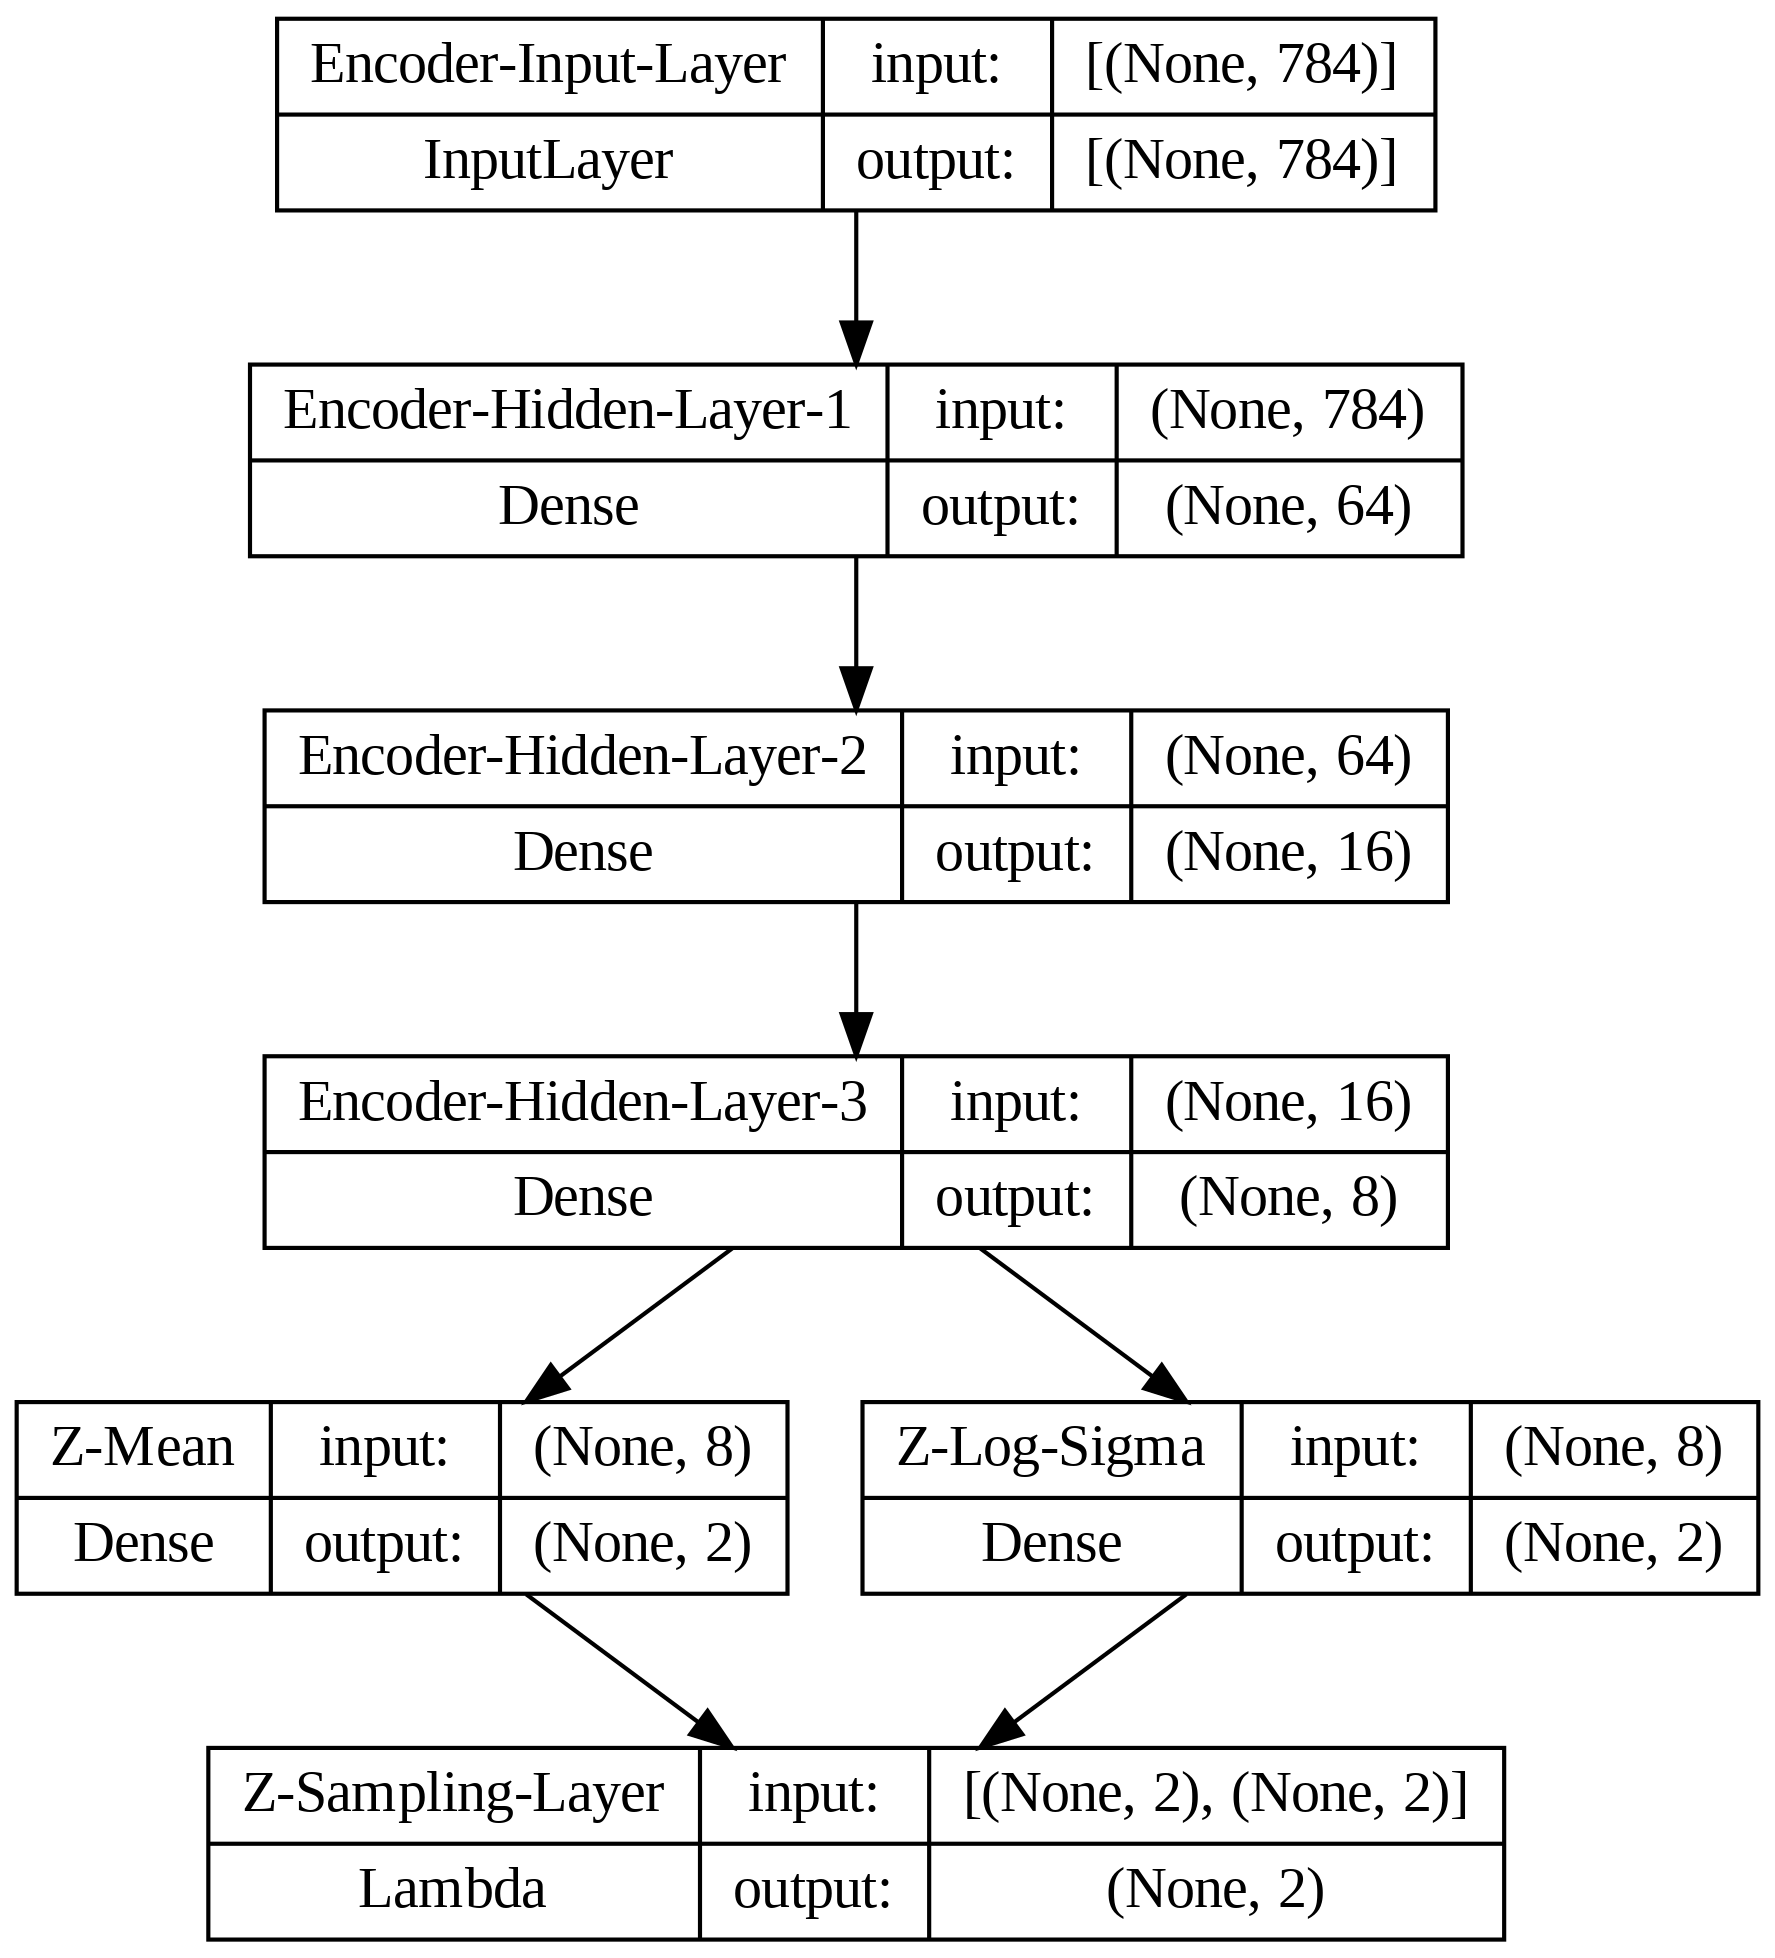

In [5]:
# Specify dimensions for input/output and latent space layers
original_dim = 784  # Number of neurons at the input layer (28 * 28 = 784)
latent_dim = 2  # Dimension of the latent space

# ********** Create Encoder **********

#--- Input Layer
# Define the input layer with the shape corresponding to the dimensions of the input data.
visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

#--- Hidden Layers
# Define the hidden layers of the encoder. These layers transform the input data into
# a more compact representation suitable for extracting meaningful features.
h_enc1 = Dense(units=64, activation='relu', name='Encoder-Hidden-Layer-1')(visible)  # First hidden layer
h_enc2 = Dense(units=16, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)   # Second hidden layer
h_enc3 = Dense(units=8, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc2)     # Third hidden layer

#--- Custom Latent Space Layer
# Define the latent space layer, where the mean and log variance of the latent space
# are computed based on the output of the encoder's hidden layers.
z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3)         # Mean component of the latent space
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3)  # Log variance component of the latent space
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma])  # Sampling layer for generating latent space representations

#--- Create Encoder model
# Construct the encoder model by specifying the input and output layers.
# The output consists of the mean, log variance, and sampled latent space representations.
encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

# Display model diagram
# Plot the architecture of the encoder model, including the shapes of input and output tensors.
plot_model(encoder, show_shapes=True, dpi=300)

Note: we send the same outputs from the Encoder-Hidden-Layer-3 into Z-Mean and Z-Log-Sigma before recombining them inside a custom Lambda layer (Z-Sampling-Layer), which is used for sampling from the latent space.

### Let's create the decoder model

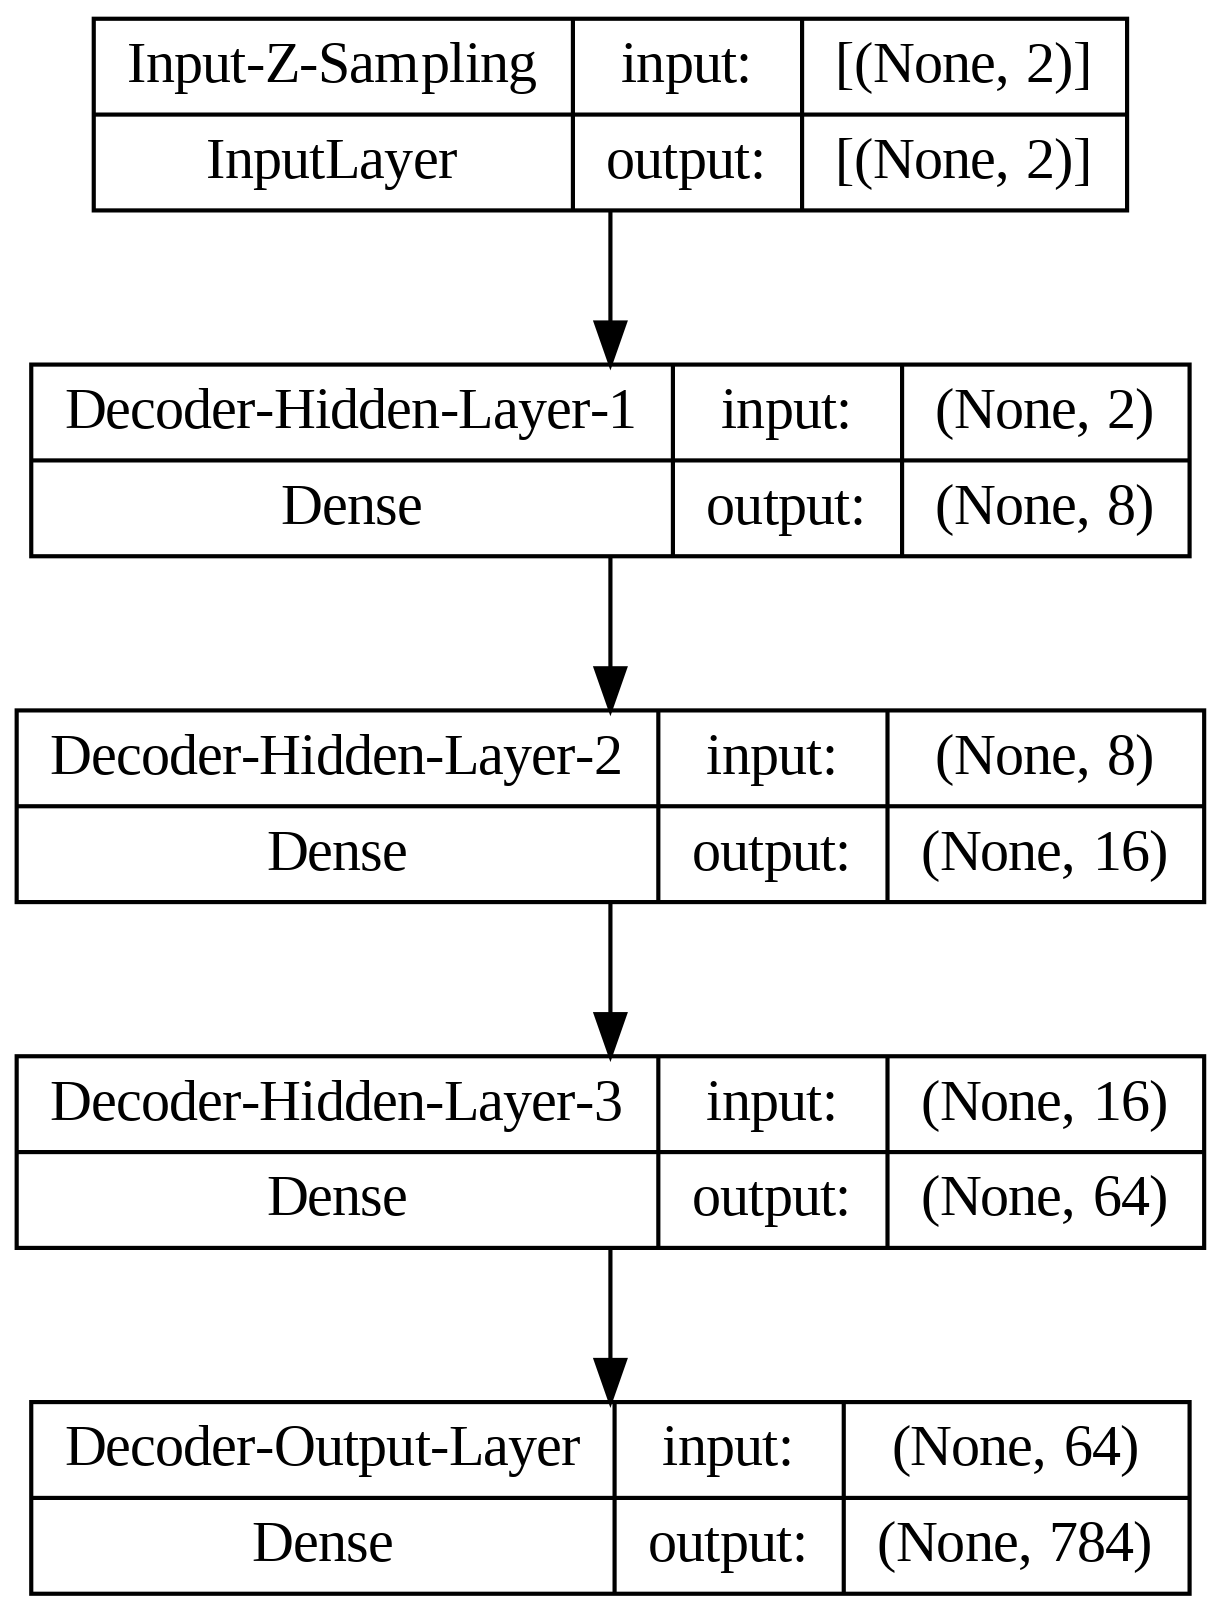

In [6]:
# ********** Create Decoder **********

#--- Input Layer
# Create an input layer for the latent space representation
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

#--- Hidden Layer
# Add hidden layers to the decoder
h_dec = Dense(units=8, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=16, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=64, activation='relu', name='Decoder-Hidden-Layer-3')(h_dec2)

#--- Output Layer
# Add an output layer to reconstruct the original input
outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)

#--- Create Decoder model
# Define the decoder model using the input and output layers
decoder = Model(latent_inputs, outputs, name='Decoder-Model')

# Display model diagram
# Plot the model diagram with shapes of input and output layers
plot_model(decoder, show_shapes=True, dpi=300)

### Let's combine both encoder and decoder models to form a Variational autoencoder model

In [7]:
# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
# Connect the decoder to the output of the encoder, passing the latent space representation (z)
# The encoder(visible)[2] selects the third output from the encoder, which is the latent space representation (z)
outpt = decoder(encoder(visible)[2])

# Instantiate a VAE model
# Create a VAE model using the input and output layers
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

- If you see the latent space layers in encoder model generates three sets of outputs: Z-mean [0], Z-log-sigma [1] and Z [2].
- Encoder takes original inputs named "visible". Then out of the three outputs generated by the Encoder [0], [1], [2], we take the third one (Z [2]) and pass it into a Decoder, which generates the outputs that we named "output".

## we need to create the custom loss function

In [8]:
# Reconstruction loss compares inputs and outputs and tries to minimize the difference
# Use mean squared error (MSE) as the reconstruction loss
r_loss = original_dim * keras.losses.mse(visible, outpt)

# KL divergence loss compares the encoded latent distribution Z with standard Normal distribution
# Penalizes if it's too different, encouraging the latent space to follow a standard Normal distribution
kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=1)

# The VAE loss is a combination of reconstruction loss and KL loss
vae_loss = K.mean(r_loss + kl_loss)

# Add the VAE loss to the model and compile it
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

- Reconstruction loss (r_loss) calculates the mean squared error between the input data (visible) and the output of the VAE model (outpt). This loss measures how well the VAE reconstructs the input data.

- KL divergence loss (kl_loss) compares the distribution of the encoded latent space (z) with a standard normal distribution. It penalizes the model if the distribution of z deviates significantly from a standard normal distribution.

- The VAE loss (vae_loss) is the sum of the reconstruction loss and the KL divergence loss. It represents the overall loss function used to train the VAE.

- The VAE loss is added to the model using vae.add_loss(vae_loss), and the model is compiled with the Adam optimizer.

## Step 4: train the data

In [9]:
# Train VAE model
# Fit the VAE model on the training data with specified parameters
history = vae.fit(X_train, X_train, epochs=25, batch_size=16, validation_data=(X_test, X_test))

Epoch 1/25
3750/3750 [==============================] - 36s 8ms/step - loss: 48.4460 - val_loss: 42.6311
Epoch 2/25
3750/3750 [==============================] - 16s 4ms/step - loss: 40.5364 - val_loss: 39.1014
Epoch 3/25
3750/3750 [==============================] - 16s 4ms/step - loss: 38.2353 - val_loss: 37.6011
Epoch 4/25
3750/3750 [==============================] - 21s 6ms/step - loss: 37.1054 - val_loss: 36.9592
Epoch 5/25
3750/3750 [==============================] - 21s 6ms/step - loss: 36.4143 - val_loss: 36.2343
Epoch 6/25
3750/3750 [==============================] - 18s 5ms/step - loss: 35.9232 - val_loss: 35.7132
Epoch 7/25
3750/3750 [==============================] - 28s 7ms/step - loss: 35.5237 - val_loss: 35.3357
Epoch 8/25
3750/3750 [==============================] - 16s 4ms/step - loss: 35.2203 - val_loss: 35.2039
Epoch 9/25
3750/3750 [==============================] - 17s 4ms/step - loss: 34.9639 - val_loss: 34.9443
Epoch 10/25
3750/3750 [==============================] 

Plot the loss chart

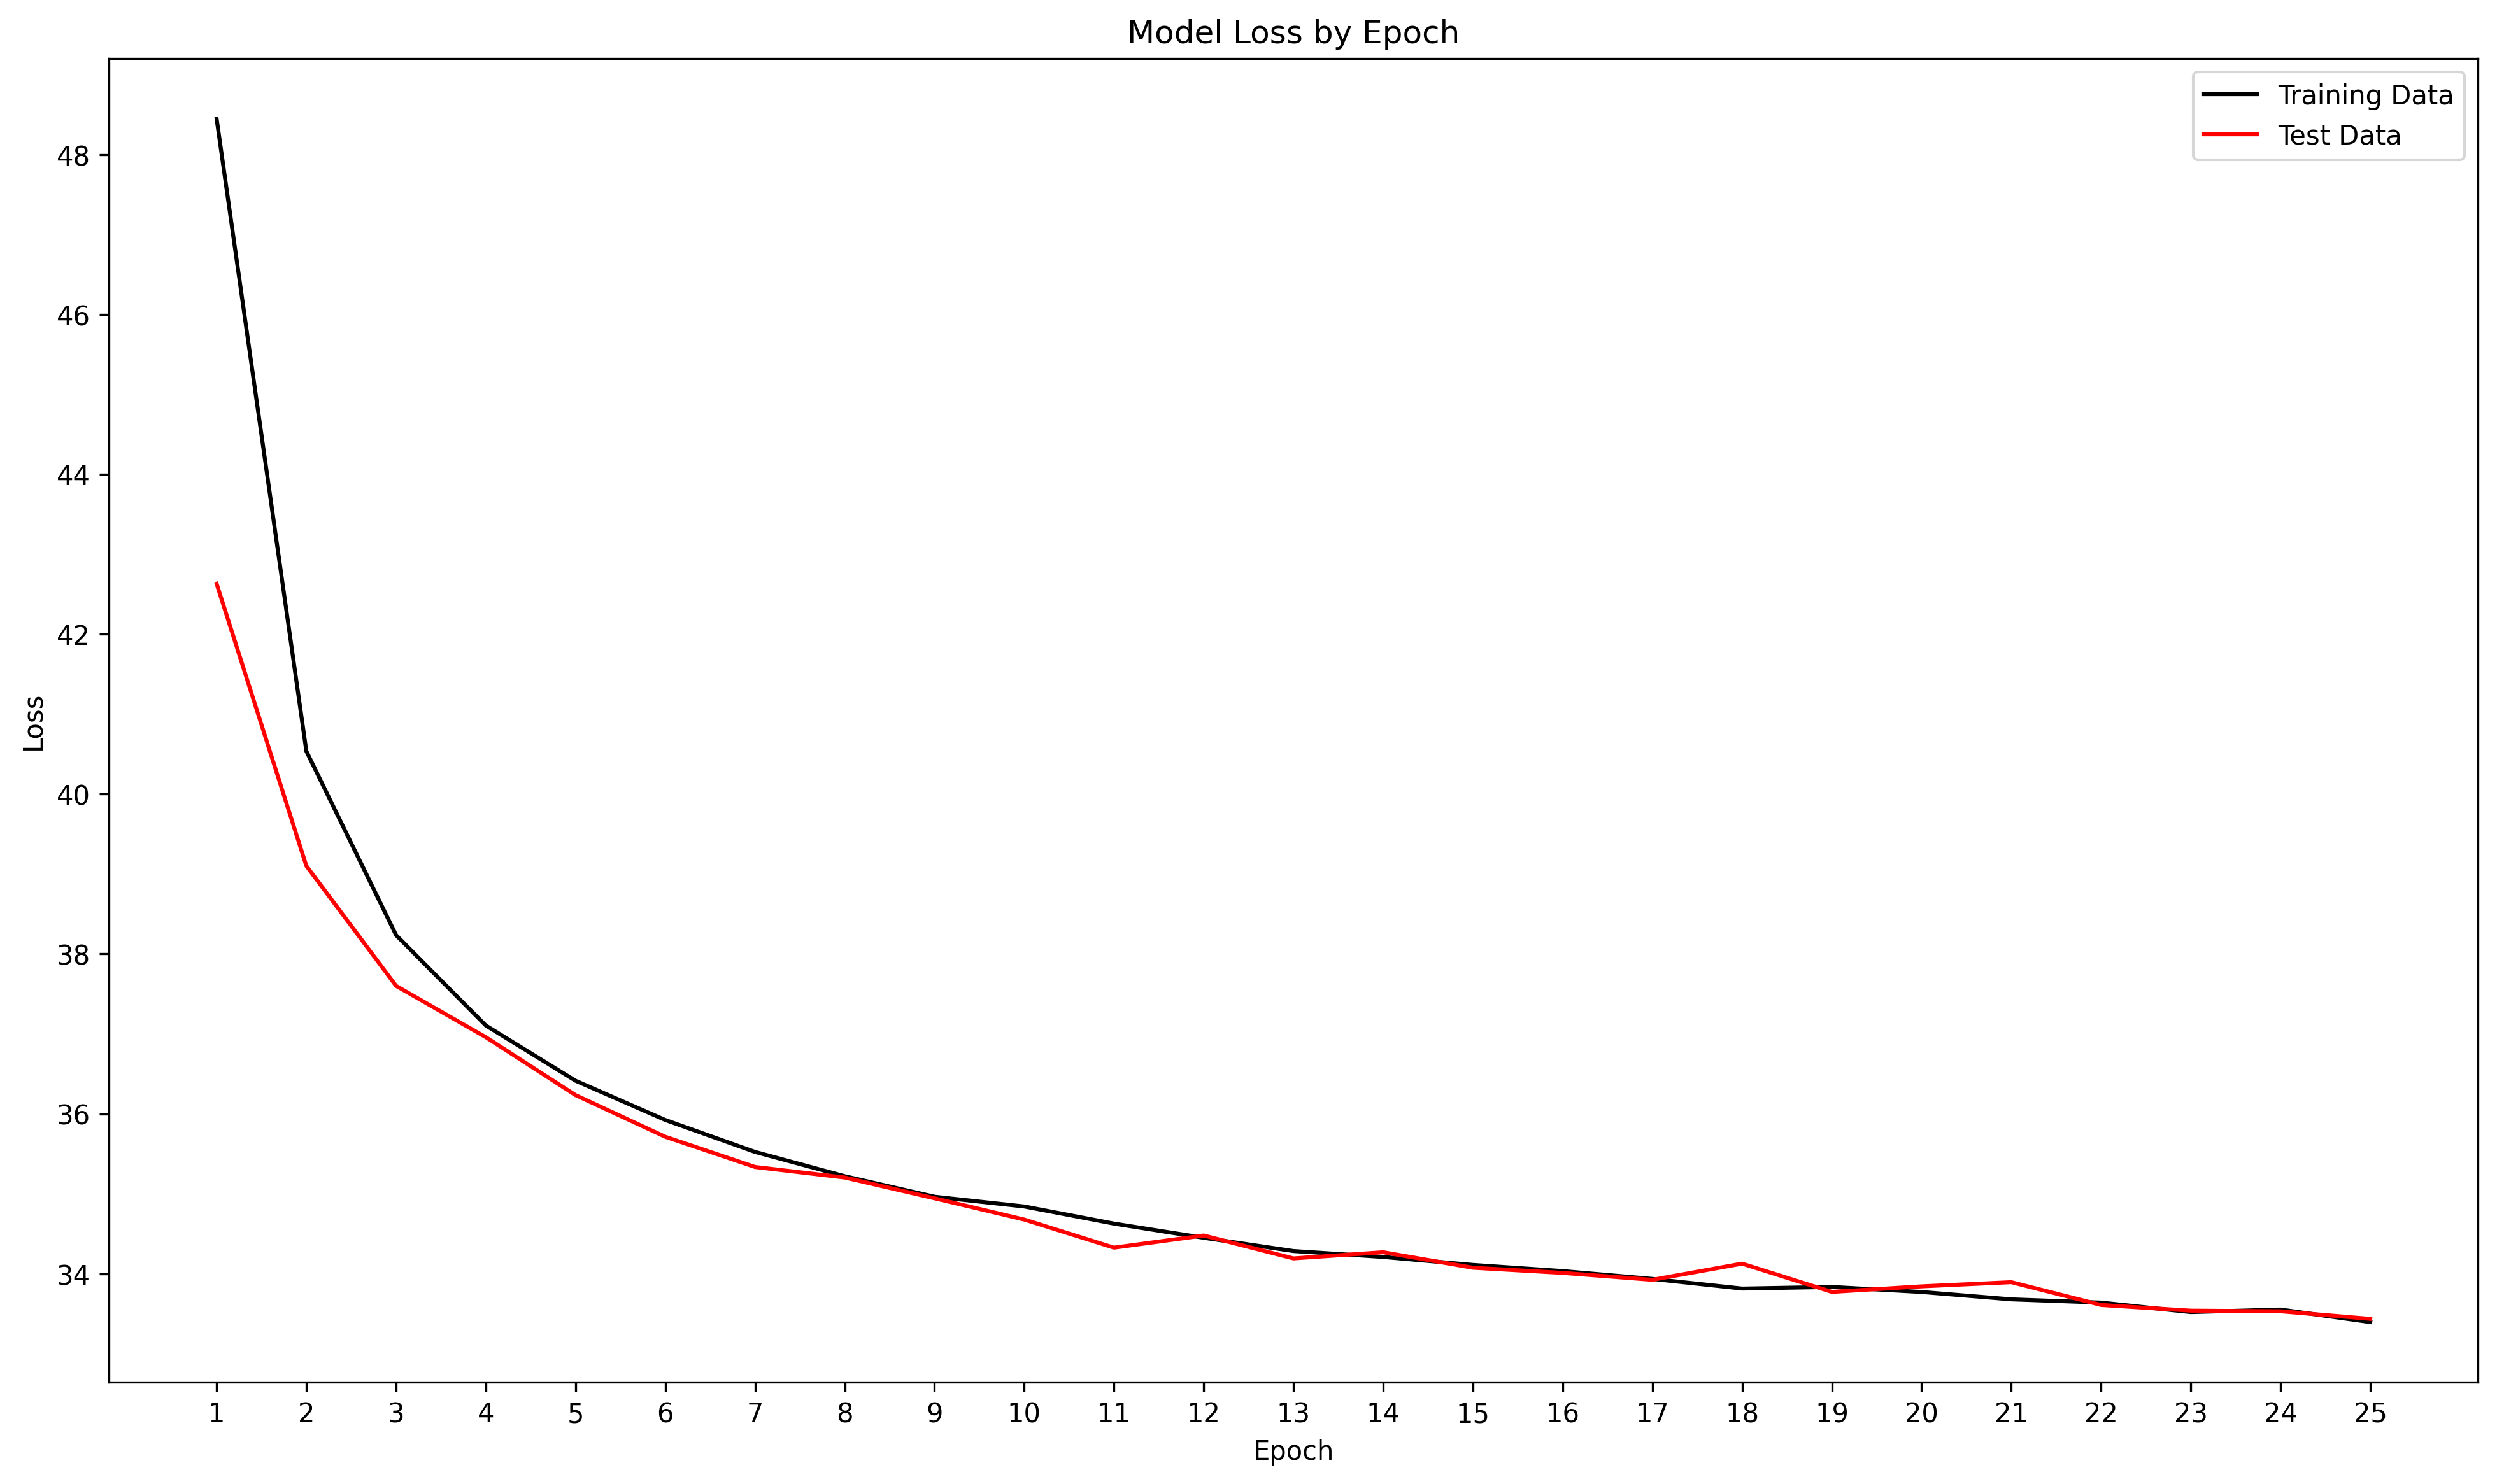

In [10]:
# Plot a loss chart
# Create a figure and axis for plotting the loss
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
# Set the title of the plot
plt.title(label='Model Loss by Epoch', loc='center')

# Plot the training loss over epochs
ax.plot(history.history['loss'], label='Training Data', color='black')
# Plot the validation loss over epochs
ax.plot(history.history['val_loss'], label='Test Data', color='red')
# Set labels for x and y axes
ax.set(xlabel='Epoch', ylabel='Loss')
# Set x-axis ticks to show each epoch
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
# Add a legend to the plot
plt.legend()
# Display the plot
plt.show()

## Visualize the latent space and generate the new digits.

Since our latent space is two-dimensional, we can visualise the neighbourhoods of different digits on the latent 2D plane

In [11]:
# Use encoder model to encode inputs into a latent space
# Encode the test data using the encoder model to obtain the latent space representation
X_test_encoded = encoder.predict(X_test)

# Recall that our encoder returns 3 arrays: z-mean, z-log-sigma, and z. We plot the values for z
# Create a scatter plot
fig = px.scatter(None, x=X_test_encoded[2][:,0], y=X_test_encoded[2][:,1],
                 opacity=1, color=y_test.astype(str))

# Change chart background color and dimensions
fig.update_layout(dict(plot_bgcolor = 'white'), margin=dict(l=0, r=0, t=40, b=0))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white',
                 zeroline=True, zerolinewidth=1, zerolinecolor='white',
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white',
                 zeroline=True, zerolinewidth=1, zerolinecolor='white',
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

# Set figure title
fig.update_layout(title_text="MNIST digit representation in the 2D Latent Space")

# Update marker size
fig.update_traces(marker=dict(size=2))

# Display the plot
fig.show()

313/313 [==============================] - 1s 2ms/step


- Each colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).

- Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

we want to generate a new image of a digit 1. We know that 1's are located in the middle right of the latent space. So let's pick the coordinates of [1, 0.09] and generate an image associated with those inputs.

1/1 [==============================] - 0s 41ms/step


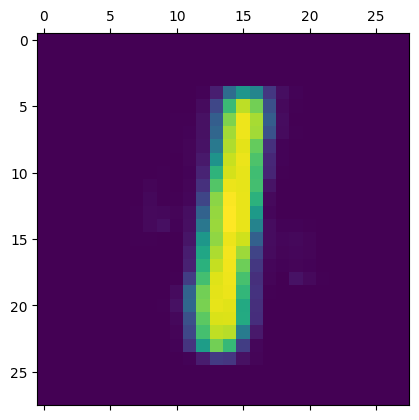

In [16]:
# Input latent space coordinates
z_sample_digit = [[1.0, 0.09]]  # Coordinates in the latent space

# Decode the latent inputs to generate new outputs (i.e., reconstruct an image)
digit_decoded = decoder.predict(z_sample_digit)

# Reshape the decoded image and display it
plt.matshow(digit_decoded.reshape(28, 28))  # Reshape to original image size and display
plt.show()

Similarly lets do for the digit 2

1/1 [==============================] - 0s 37ms/step


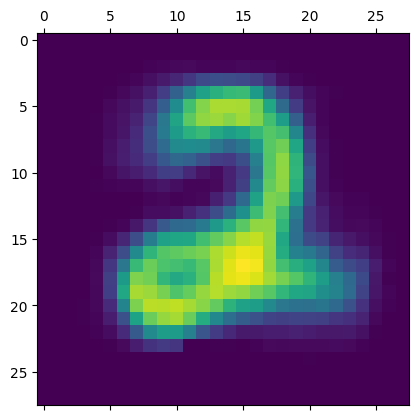

In [19]:
# Input latent space coordinates
z_sample_digit = [[-0.3, -1.3]]  # Coordinates in the latent space

# Decode the latent inputs to generate new outputs (i.e., reconstruct an image)
digit_decoded = decoder.predict(z_sample_digit)

# Reshape the decoded image and display it
plt.matshow(digit_decoded.reshape(28, 28))  # Reshape to original image size and display
plt.show()

As we got the image shape closely. lets generate 900 new digits across the whole latent space.

In [22]:
# Display a 2D manifold of the digits
n = 30  # figure with 30x30 digits
digit_size = 28  # size of each digit image

# Initialize an empty image
figure = np.zeros((digit_size * n, digit_size * n))

# Define the grid of points in the latent space
grid_x = np.linspace(1.5, -1.5, n)
grid_y = np.linspace(-1.5, 1.5, n)

# Iterate over each point in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # Generate a sample in the latent space
        z_sample = np.array([[xi, yi]])

        # Decode the sample to generate an image
        x_decoded = decoder.predict(z_sample)

        # Clip pixel values to ensure they are within a certain range
        x_decoded = np.clip(x_decoded, 0.25, 0.75)

        # Reshape the decoded image to its original size
        digit = x_decoded[0].reshape(digit_size, digit_size)

        # Insert the decoded digit into the figure at the appropriate location
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit


1/1 [==============================] - 0s 27ms/step


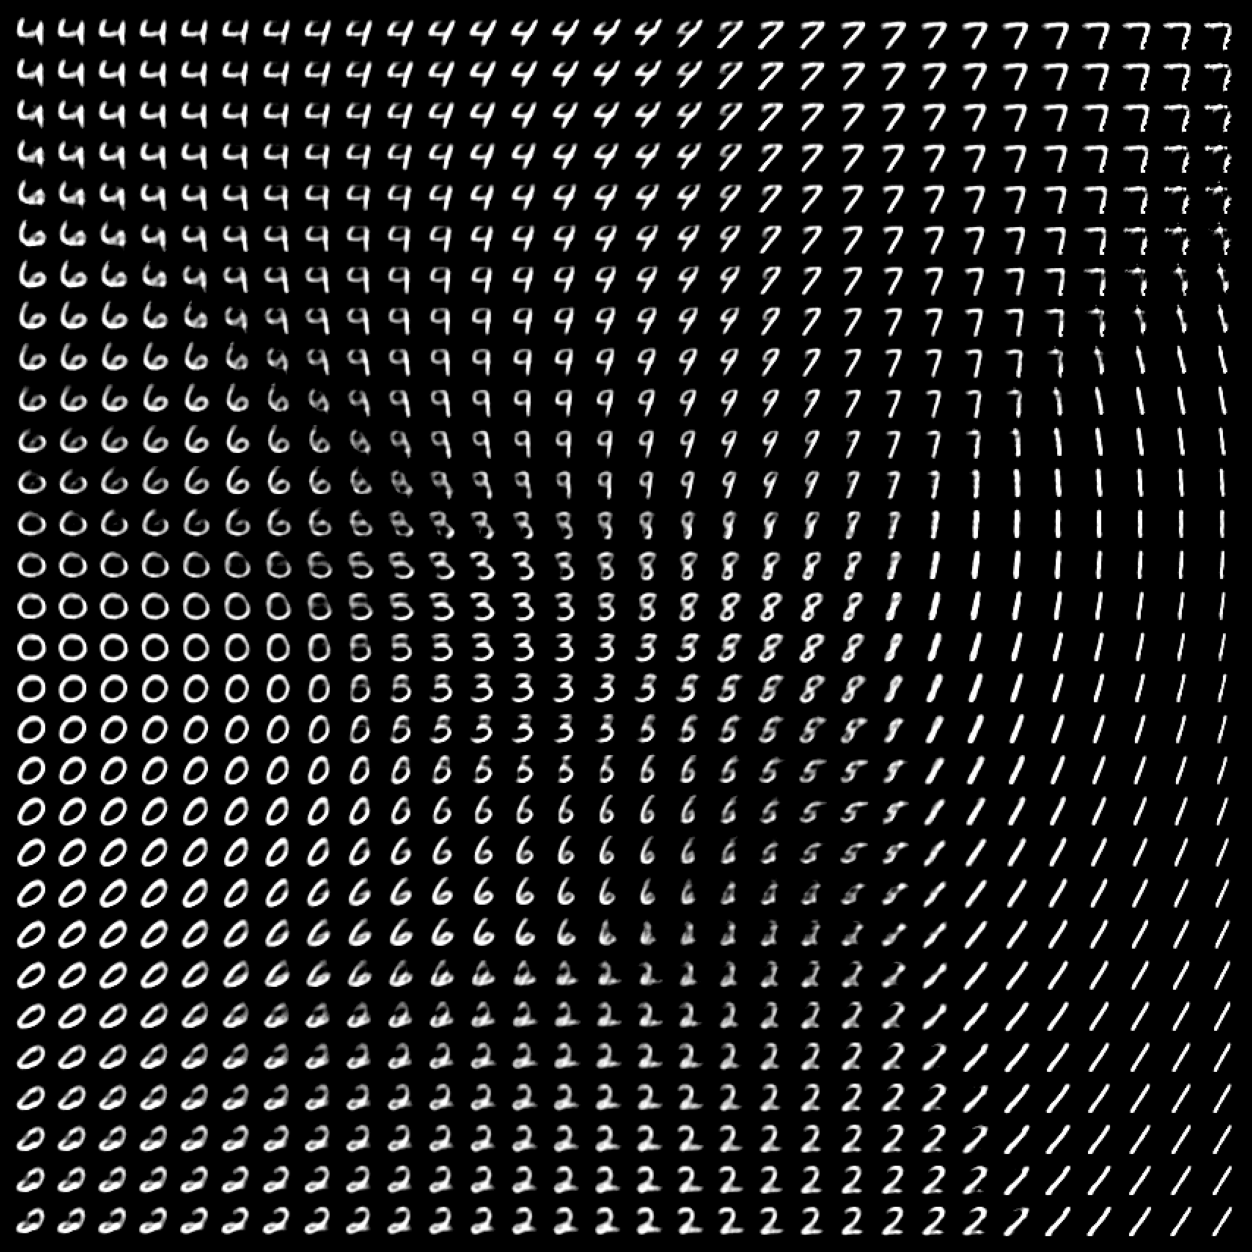

In [32]:
# Plot the figure
fig = plt.figure(figsize=(18, 16))
fig.set_facecolor('black')  # Set the background color to light grey
plt.imshow(figure, cmap='gray')  # Display the image in grayscale
plt.axis('off')  # Hide the axes
plt.show()

By generating many images from the entire latent space we can see gradual transition between different shapes. This shows we have done the regularization our latent space successfully.

<p align="center"><font size = ""><b> -- End of program -- </b><font></p>
<p align="center"><font size = "10"><b> Happy coding! ☺ </b><font></p>